In [1]:
import os
import pandas as pd
import numpy as np

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

In [2]:
def group_f1_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    try: 
        score = metrics.roc_auc_score(label, pred)
    except: 
        score = np.nan
    return score

In [3]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    # pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    # pred_b = softmax(pred_b)
    # return pred_b[1] # the probability to greater label
    return pred[2]+pred[3]

In [4]:
def convert2cls(chir, csp_category): 
    if csp_category == '1' or csp_category == 1: 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2' or csp_category == 2: 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

## 1. Load prediction results

In [5]:
dfs = []
for mb in range(18): 
    dfs.append(pd.read_csv('../results0724/molnet_cmrt_cls_etkdg_csp{}.csv'.format(str(mb)), 
                               sep='\t', index_col=0))
    df_pred = pd.concat(dfs, ignore_index=True)

In [6]:
df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)

In [7]:
df_pred = df_pred.sort_values(['SMILES', 'MB', 'Pred_b'], 
                              ascending=False).drop_duplicates(['SMILES', 'MB'], 
                                                               keep='first').sort_index()

In [8]:
df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)

In [9]:
df_pred

,SMILES,MB,Pred,Pred_b
0,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,0,"2.5496970920357853e-05,0.9588855504989624,0.04...",0.041089
1,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1,0,"7.296912372112274e-06,0.004127092659473419,0.9...",0.995866
2,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,0,"3.5950242818216793e-06,0.9999326467514038,6.05...",0.000064
3,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,0,"5.340648385754321e-06,0.9984808564186096,0.001...",0.001514
4,Cc1ccc(S(=O)(=O)C[C@H]2CCCc3ccccc32)cc1,0,"1.3105311325034563e-07,0.9999988079071045,1.41...",0.000001
...,...,...,...,...
97303,CC(=O)NN[C@@H](/C=C/c1ccccc1)c1ccc(C)cc1,17,"0.28571617603302,0.005027764476835728,0.705370...",0.709256
97304,O=C1O[C@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccc...,17,"0.0001498589408583939,7.59070971980691e-05,0.9...",0.999774
97305,O=C1O[C@@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2cc...,17,"0.00015381925913970917,0.00010073754674522206,...",0.999745
97306,COC(=O)C[C@@H](O)c1ccc(N(C)C)cc1,17,"0.0543239451944828,0.007386163342744112,0.9313...",0.938290


## 2. Load CMRT

In [10]:
suppl = Chem.SDMolSupplier("../data/CMRT/cmrt_clean.sdf")
mols = [x for x in suppl if x is not None]

In [11]:
df_dict = {'SMILES': [], 'MB': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['Y'].append(y)

df_label = pd.DataFrame.from_dict(df_dict)

In [12]:
df_label = df_label.sort_values(['SMILES', 'MB', 'K2/K1'], 
                              ascending=False).drop_duplicates(['SMILES', 'MB'], 
                                                               keep='first').sort_index()

In [13]:
df_label

,SMILES,MB,K2/K1,Y
0,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,0.7792,0
1,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,0.7792,0
2,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,16,0.3095,0
3,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,16,0.3095,0
4,Cc1ccc(S(=O)(=O)C[C@H]2CCCc3ccccc32)cc1,0,2.7838,3
...,...,...,...,...
5401,CC(=O)NN[C@@H](/C=C/c1ccccc1)c1ccc(C)cc1,6,1.0833,1
5402,O=C1O[C@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccc...,16,1.2459,2
5403,O=C1O[C@@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2cc...,16,1.2459,2
5404,COC(=O)C[C@@H](O)c1ccc(N(C)C)cc1,16,1.1218,0


## 3. Merge

In [14]:
df_csp = pd.read_csv('../preprocess/chirality_stationary_phase_list.csv').dropna()

Convert isomer SMILES into regular SMILES

In [40]:
df_pred['SMILES_iso'] = df_pred['SMILES']
df_label['SMILES_iso'] = df_label['SMILES']

df_pred['SMILES'] = df_pred['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_label['SMILES'] = df_label['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [53]:
df_pred['MB'] = df_pred['MB'].astype(int)
df_label['MB'] = df_label['MB'].astype(int)

df_cmrt = df_pred.merge(df_label, on=['SMILES_iso', 'SMILES', 'MB'], how='right').dropna()
df_cmrt['Y_b'] = df_cmrt['Y'].apply(binary_cls)

df_cmrt0 = df_cmrt[df_cmrt['Y_b'] == 0]
df_cmrt1 = df_cmrt[df_cmrt['Y_b'] == 1]

df_cmrt0 = df_cmrt0.sort_values(['SMILES', 
                                 'MB', 
                                 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 
                                                                              'MB'], keep='last').sort_index()

df_cmrt1 = df_cmrt1.sort_values(['SMILES', 
                                 'MB', 
                                 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 
                                                                              'MB'], keep='first').sort_index()

df_cmrt = pd.concat([df_cmrt0, df_cmrt1])

In [54]:
df_cmrt

,SMILES,MB,Pred,Pred_b,SMILES_iso,K2/K1,Y,Y_b
3,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,16,"0.6372742056846619,0.003919125534594059,0.3473...",0.358807,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,0.7792,0,0
6,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,16,"0.09225121140480042,3.559917558959569e-06,0.90...",0.907745,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,0.3095,0,0
51,CC(CS(C)(=O)=O)c1ccccc1,14,"0.961402952671051,0.032029345631599426,0.00272...",0.006568,CC(CS(C)(=O)=O)c1ccccc1,1.1754,1,0
82,CC(C#N)c1cccc2ccccc12,9,"0.001363738439977169,0.35946980118751526,0.639...",0.639166,CC(C#N)c1cccc2ccccc12,1.1343,1,0
175,C#CC(C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,8,"0.0007363500189967453,0.0006555097061209381,0....",0.998608,C#CC(C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,1.1170,1,0
...,...,...,...,...,...,...,...,...
10378,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)CC1C(F)(F)F,0,"0.00042064193985424936,0.03283034637570381,7.5...",0.966749,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)CC1C(F)(F)F,1.5388,2,1
10382,CC1=NN(c2ccccc2)C(=O)C1(CC=Cc1ccccc1)Cc1ccccc1,16,"3.37702440447174e-05,3.7788774989166996e-06,0....",0.999962,CC1=NN(c2ccccc2)C(=O)C1(CC=Cc1ccccc1)Cc1ccccc1,1.4980,2,1
10385,C=CC1(O)C(=O)N(Cc2ccccc2)c2ccccc2C1(CBr)c1ccccc1,16,"0.03295019268989563,0.004480193834751844,0.962...",0.962570,C=CC1(O)C(=O)N(Cc2ccccc2)c2ccccc2C1(CBr)c1ccccc1,1.4636,2,1
10397,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,0,"6.910559022799134e-07,9.83686874178602e-08,0.9...",0.999999,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,1.4901,2,1


Calculate metrics (AUC, ACC, KAPPA, F1, COUNT)

In [55]:
df_cmrt['Class_b'] = df_cmrt['Y'].apply(binary_cls)

In [56]:
auc = df_cmrt.groupby('MB').apply(group_auc_b)
acc = df_cmrt.groupby('MB').apply(group_acc_b)
kappa = df_cmrt.groupby('MB').apply(group_kappa_b)
f1 = df_cmrt.groupby('MB').apply(group_f1_b)
cnt = df_cmrt.groupby('MB').size()

In [57]:
df_res_all = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_all.reset_index(inplace=True)
df_res_all = df_res_all.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_all = df_res_all.merge(df_csp, left_on='MB', right_on='CSP_Encode')

Calculate \#Class1 / \#Class0

In [58]:
df_res_all_class_cnt = df_cmrt.groupby('MB').value_counts(subset=['Class_b']).reset_index()

df_res_all_class_ratio = df_res_all_class_cnt.groupby('MB').apply(lambda x: 
                x[x['Class_b'] == 0]['count'].values[0] / x[x['Class_b'] == 1]['count'].values[0]).to_frame(name='Class1/Class0')

df_res_all = df_res_all.merge(df_res_all_class_ratio, on='MB')

In [59]:
df_res_all

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category,Class1/Class0
0,0,0.583217,0.698246,0.026995,0.698246,285,Chiralpak IB,IB,91423,0,2,0.295455
1,6,0.729412,0.803922,0.294118,0.803922,102,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2,0.200000
2,8,0.689775,0.790698,0.194798,0.790698,172,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2,0.237410
3,9,0.705435,0.677632,0.307292,0.677632,152,Chiralpak AS,AS,45167,9,2,0.652174
4,11,0.826912,0.832714,0.348949,0.832714,269,Chiralpak AD,AD,23735,11,2,0.211712
5,14,0.690518,0.661814,0.265613,0.661814,893,Chiralpak IC (Sepapak 5),IC,91518,14,1,0.563923
6,16,0.703150,0.660739,0.239372,0.660739,731,Chiralpak IA,IA,45172,16,1,0.653846


### Check the results on overlapped molecules (CMRT & ChirBase)

In [60]:
df_overlap = pd.read_csv('../data/compare_chirbase_cmrt.csv')

df_overlap = df_overlap.sort_values(['SMILES', 'Column_x', 'K2/K1_x'], 
                              ascending=False).drop_duplicates(['SMILES', 'Column_x'], 
                                                               keep='first').sort_index()

df_overlap = df_overlap.merge(df_csp, left_on='Column_x', right_on='Short_Name', how='left')

df_overlap = df_overlap.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

Calculate metrics (Prediction v.s. CMRT labels)

In [61]:
df_overlap['Consistency_b'] = df_overlap.apply(lambda x: 1 if x['Y_x2'] == x['Y_y2'] else 0, axis=1)

In [62]:
auc = df_overlap.groupby('MB').apply(group_auc_b)
acc = df_overlap.groupby('MB').apply(group_acc_b)
kappa = df_overlap.groupby('MB').apply(group_kappa_b)
f1 = df_overlap.groupby('MB').apply(group_f1_b)
cnt = df_overlap.groupby('MB').size()

/home/yuhhong/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [63]:
df_res = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res.reset_index(inplace=True)
df_res = df_res.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_overlap = df_res.merge(df_csp, left_on='MB', right_on='CSP_Encode')

In [64]:
df_res_overlap_class_cnt = df_cmrt.groupby('MB').value_counts(subset=['Class_b']).reset_index()
df_res_overlap_class_ratio = df_res_overlap_class_cnt.groupby('MB').apply(lambda x: 
                x[x['Class_b'] == 0]['count'].values[0] / x[x['Class_b'] == 1]['count'].values[0]).to_frame(name='Class1/Class0')

df_red_overlap_consistency_ratio = df_overlap.groupby('MB').apply(lambda x: 
                    x['Consistency_b'].sum()/len(x['Consistency_b'])).reset_index().rename(columns={0: 'Consist_RATIO'})

df_res_overlap = df_res_overlap.merge(df_res_overlap_class_ratio, on='MB')
df_res_overlap = df_res_overlap.merge(df_red_overlap_consistency_ratio, on='MB')

In [65]:
df_res_overlap

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category,Class1/Class0,Consist_RATIO
0,6,1.000000,0.800000,0.000000,0.800000,5,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2,0.200000,0.800000
1,8,NaN,1.000000,NaN,1.000000,8,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2,0.237410,1.000000
2,9,1.000000,0.923077,0.847059,0.923077,13,Chiralpak AS,AS,45167,9,2,0.652174,0.923077
3,11,1.000000,0.928571,0.857143,0.928571,14,Chiralpak AD,AD,23735,11,2,0.211712,1.000000
4,14,1.000000,1.000000,1.000000,1.000000,21,Chiralpak IC (Sepapak 5),IC,91518,14,1,0.563923,1.000000
5,16,0.965278,0.960000,0.911032,0.960000,25,Chiralpak IA,IA,45172,16,1,0.653846,0.960000


In [66]:
with pd.ExcelWriter('test_cmrt.xlsx') as writer:  
    df_res_all.to_excel(writer, sheet_name='all')
    df_res_overlap.to_excel(writer, sheet_name='overlap')

### Plot!!

In [67]:
def plot_roc_curve_b(pred, target, name=None, save_fig=False, print_confusion_metrics=False): 
    f, ax = plt.subplots(figsize=(6, 6))

    fpr, tpr, thresh = metrics.roc_curve(target, pred)
    auc = metrics.roc_auc_score(target, pred)
    ax.plot(fpr, tpr, label="super-class 1 vs the rest (AUC={:.2f})".format(auc))

    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("CSP {}".format(name))
    ax.legend()

    if save_fig: 
        plt.savefig('./roc_curve_{}.png'.format(str(mb_idx)), dpi=300, bbox_inches='tight')
        print('Save!')
    plt.show()
    
    # confusion metrics
    if print_confusion_metrics: 
        pred = np.argmax(pred_prob, axis=1)
        print('confusion metrics: \n[[tn, fp], \n[fn, tp]]\n')
        print(metrics.multilabel_confusion_matrix(df_tmp['Class'].to_numpy(), pred))

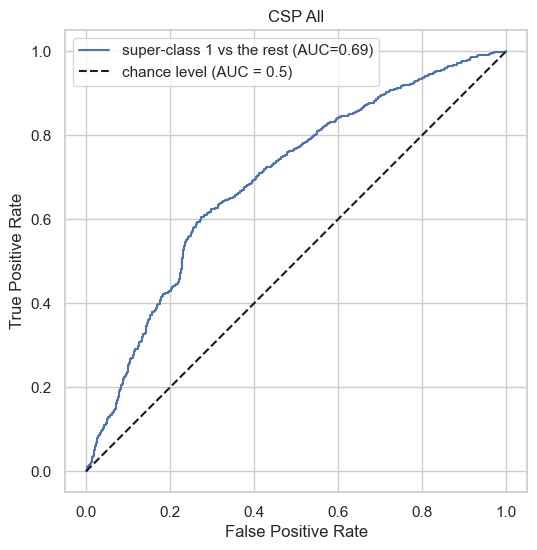

In [68]:
plot_roc_curve_b(df_cmrt['Pred_b'], df_cmrt['Class_b'], name='All')

In [69]:
# grouped = df_cmrt.groupby('MB')

# for name, group in grouped: 
#     print(len(group), len(group[group['Class_b']==1]))
#     plot_roc_curve_b(group['Pred_b'], group['Class_b'], name)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


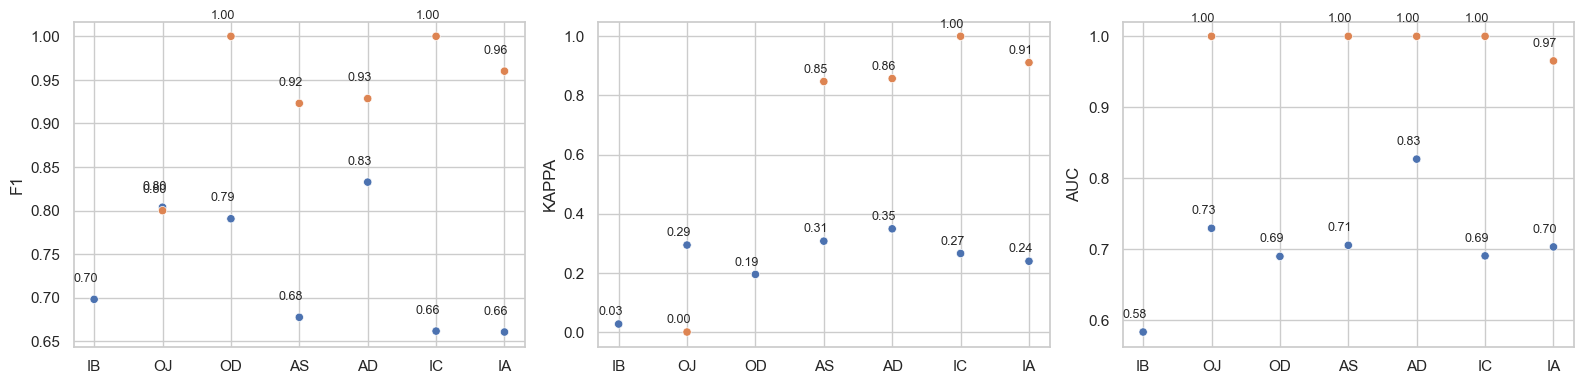

In [70]:
CSP_dict = {'IB': 0, 'OJ': 1, 'OD': 2, 'AS': 3, 'AD': 4, 'IC': 5, 'IA': 6}
# CSP_dict = {'OD': 0, 'AS': 1, 'AD': 2, 'IC': 3, 'IA': 4}
# IB: do not have overlap
# OJ: only have one positive sample
# OD: no positive samples

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

df_res_all['Label'] = 'All'
df_res_overlap['Label'] = 'Overlap'
df_res = pd.concat([df_res_all, df_res_overlap])
df_res_plot = df_res[df_res['Short_Name'].isin(CSP_dict.keys())]

sns.scatterplot(data=df_res_plot, x="Short_Name", y="AUC", hue='Label', ax=axs[2], legend=False)
axs[2].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="KAPPA", hue='Label', ax=axs[1], legend=False)
axs[1].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="F1", hue='Label', ax=axs[0], legend=False)
axs[0].set(xlabel=None)


for i, point in df_res_plot.iterrows(): 
    axs[2].text(CSP_dict[point['Short_Name']]-0.3, point['AUC']+0.02, '{:.2f}'.format(point['AUC']), fontsize=9)
    axs[1].text(CSP_dict[point['Short_Name']]-0.3, point['KAPPA']+0.03, '{:.2f}'.format(point['KAPPA']), fontsize=9)
    axs[0].text(CSP_dict[point['Short_Name']]-0.3, point['F1']+0.02, '{:.2f}'.format(point['F1']), fontsize=9)
    
fig.tight_layout()
plt.savefig('./test_cmrt.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./test_cmrt.png', dpi=600, bbox_inches='tight')
plt.show()

/home/yuhhong/anaconda3/envs/molnet_pp/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


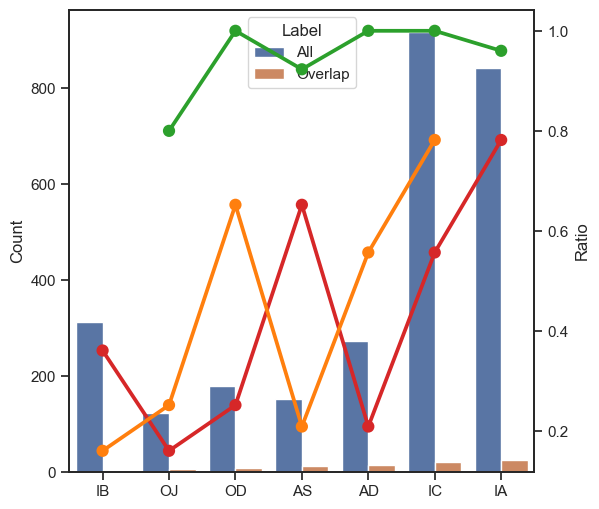

In [33]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 6))

sns.barplot(data=df_res, x="Short_Name", y="COUNT", hue='Label', ax=ax,)

ax2 = ax.twinx()
sns.pointplot(data=df_res[df_res['Label']=='All'], x="Short_Name", y="Class1/Class0", ax=ax2, 
              label='Class1/Class0', color='tab:red')
sns.pointplot(data=df_res[df_res['Label']=='Overlap'], x="Short_Name", y="Class1/Class0", ax=ax2, 
              label='Class1/Class0', color='tab:orange')
sns.pointplot(data=df_res, x="Short_Name", y="Consist_RATIO", ax=ax2, 
              label='Consistency Ratio', color='tab:green')
ax.set(xlabel='', ylabel='Count')
ax2.set(xlabel='', ylabel='Ratio')

plt.show()

In [34]:
# fig, axs = plt.subplots(2, 1, figsize=(9, 6))

# sns.pointplot(data=df_res_all, x="Short_Name", y="Class1/Class0", ax=axs[0], 
#               label='#Class1/#Class0', color='tab:blue')
# sns.pointplot(data=df_res_all, x="Short_Name", y="AUC", ax=axs[0], 
#               label='AUC', color='tab:red')
# sns.pointplot(data=df_res_all, x="Short_Name", y="F1", ax=axs[0], 
#               label='F1', color='tab:green')
# axs[0].set(xlabel=None, ylabel=None)
# axs[0].legend()

# sns.pointplot(data=df_res_overlap, x="Short_Name", y="Class1/Class0", ax=axs[1], 
#               label='#Class1/#Class0', color='tab:blue')
# sns.pointplot(data=df_res_overlap, x="Short_Name", y="AUC", ax=axs[1], 
#               label='AUC', color='tab:red')
# sns.pointplot(data=df_res_overlap, x="Short_Name", y="F1", ax=axs[1], 
#               label='F1', color='tab:green')
# axs[1].set(xlabel=None, ylabel=None)
# axs[1].legend()

# plt.show()

## 4. Check the metrics in overlap

- Model(9:1) prediction v.s. ChirBase
- Model(9:1) prediction v.s. CMRT
- Model(5-fold) prediction v.s. ChirBase
- Model(5-fold) prediction v.s. CMRT

In [35]:
len(df_overlap)

86

**Model(9:1) prediction v.s. ChirBase**

In [36]:
df_overlap_tmp = df_overlap.copy()
df_overlap_tmp['Class_b'] = df_overlap['Y_y2']

auc = df_overlap_tmp.groupby('MB').apply(group_auc_b)
acc = df_overlap_tmp.groupby('MB').apply(group_acc_b)
kappa = df_overlap_tmp.groupby('MB').apply(group_kappa_b)
f1 = df_overlap_tmp.groupby('MB').apply(group_f1_b)
cnt = df_overlap_tmp.groupby('MB').size()

df_res_tmp = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_tmp.reset_index(inplace=True)
df_res_tmp = df_res_tmp.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_overlap_chirbase = df_res_tmp.merge(df_csp, left_on='MB', right_on='CSP_Encode')

/home/yuhhong/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/yuhhong/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [37]:
df_res_overlap_chirbase

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,6,NaN,1.000000,NaN,1.000000,5,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2
1,8,NaN,1.000000,NaN,1.000000,8,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2
2,9,0.875000,0.615385,0.315789,0.615385,13,Chiralpak AS,AS,45167,9,2
3,11,0.479167,0.571429,0.192308,0.571429,14,Chiralpak AD,AD,23735,11,2
4,14,1.000000,1.000000,1.000000,1.000000,21,Chiralpak IC (Sepapak 5),IC,91518,14,1
5,16,1.000000,0.920000,0.827586,0.920000,25,Chiralpak IA,IA,45172,16,1


**Model(9:1) prediction v.s. CMRT**

In [38]:
df_overlap_tmp = df_overlap.copy()
df_overlap_tmp['Class_b'] = df_overlap['Y_x2']

auc = df_overlap_tmp.groupby('MB').apply(group_auc_b)
acc = df_overlap_tmp.groupby('MB').apply(group_acc_b)
kappa = df_overlap_tmp.groupby('MB').apply(group_kappa_b)
f1 = df_overlap_tmp.groupby('MB').apply(group_f1_b)
cnt = df_overlap_tmp.groupby('MB').size()

df_res_tmp = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_tmp.reset_index(inplace=True)
df_res_tmp = df_res_tmp.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_overlap_cmrt = df_res_tmp.merge(df_csp, left_on='MB', right_on='CSP_Encode')

/home/yuhhong/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [39]:
df_res_overlap_cmrt

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,6,1.000000,0.800000,0.000000,0.800000,5,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2
1,8,NaN,1.000000,NaN,1.000000,8,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2
2,9,0.952381,0.692308,0.409091,0.692308,13,Chiralpak AS,AS,45167,9,2
3,11,0.479167,0.571429,0.192308,0.571429,14,Chiralpak AD,AD,23735,11,2
4,14,1.000000,1.000000,1.000000,1.000000,21,Chiralpak IC (Sepapak 5),IC,91518,14,1
5,16,0.944444,0.880000,0.745763,0.880000,25,Chiralpak IA,IA,45172,16,1


**Load the results of Model(5-fold)**

In [40]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results/molnet_chirality_cls_etkdg_csp{}-5fold_tl_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
    df = pd.concat(dfs, ignore_index=True)

In [41]:
df['SMILES'] = df['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [42]:
df = df.sort_values(['SMILES', 'MB', 'Class'], ascending=False).drop_duplicates(['SMILES', 'MB'], keep='first').sort_index()

In [43]:
df

,SMILES,MB,Class,Pred
0,C=CCc1ccccc1OCC(O)CNC(C)C,0,3,"0.0020866082049906254,0.014219977892935276,0.0..."
1,COc1ccc(C2CCCn3nc(-c4ccc(-n5cnc(C)c5)c(OC)n4)n...,0,2,"0.0007065583486109972,0.0007496289908885956,0...."
2,COc1nc(-c2nc3n(n2)CCCC3c2ccc(C(F)(F)F)cc2F)ccc...,0,2,"0.001747628441080451,5.960829639661824e-06,0.9..."
3,C=CC(CNCc1ccc(OC)cc1)n1ccc2c([N+](=O)[O-])cccc21,0,3,"3.287104846094735e-05,0.000531266734469682,0.0..."
4,Cc1ccsc1C1(CC=COC(=O)C(C)(C)C)C(=O)N(C)c2ccccc21,0,2,"0.00012049739598296583,0.0037947266828268766,0..."
...,...,...,...,...
76652,CCOC(=O)C1=C(C)Nc2cc[nH]c(=O)c2C1c1ccccc1C(F)(F)F,17,2,"3.926967906409118e-07,3.5613723525784735e-08,0..."
76656,COc1cc(C(C#N)(CCCN(C)CCc2ccc(OC)c(OC)c2)C(C)C)...,17,3,"2.866523800548748e-06,8.9267770817969e-05,0.99..."
76669,CC(C)(C)OC(=O)NC(CCCNC(=O)OCC1c2ccccc2-c2ccccc...,17,2,"2.943241952380049e-07,2.014729005850313e-08,0...."
76678,O=C1CCN2CCc3c(oc4ccccc34)C2C1,17,2,"0.0009841542923823,2.720266593314591e-06,0.999..."


In [44]:
# grouped = df.groupby(by=['SMILES', 'MB'])
# grouped.filter(lambda x: len(x) > 1)

**Model(5-fold) prediction v.s. ChirBase**

In [45]:
df_overlap_tmp = df_overlap[['SMILES', 'MB']].merge(df, 
                                                    left_on=['SMILES', 'MB'], 
                                                    right_on=['SMILES', 'MB'], 
                                                    how='left').dropna()

df_overlap_tmp['Class_b'] = df_overlap_tmp['Class'].apply(binary_cls)
df_overlap_tmp['Pred_b'] = df_overlap_tmp['Pred'].apply(binary_pred)

auc = df_overlap_tmp.groupby('MB').apply(group_auc_b)
acc = df_overlap_tmp.groupby('MB').apply(group_acc_b)
kappa = df_overlap_tmp.groupby('MB').apply(group_kappa_b)
f1 = df_overlap_tmp.groupby('MB').apply(group_f1_b)
cnt = df_overlap_tmp.groupby('MB').size()

df_res_tmp = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_tmp.reset_index(inplace=True)
df_res_tmp = df_res_tmp.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_overlap_chirbase2 = df_res_tmp.merge(df_csp, left_on='MB', right_on='CSP_Encode')

/home/yuhhong/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/yuhhong/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [46]:
df_res_overlap_chirbase2

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,6,NaN,1.000000,NaN,1.000000,5,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2
1,8,NaN,1.000000,NaN,1.000000,8,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2
2,9,1.000000,1.000000,1.000000,1.000000,13,Chiralpak AS,AS,45167,9,2
3,11,0.687500,0.785714,0.588235,0.785714,14,Chiralpak AD,AD,23735,11,2
4,14,0.663462,0.571429,0.152466,0.571429,21,Chiralpak IC (Sepapak 5),IC,91518,14,1
5,16,1.000000,0.960000,0.904943,0.960000,25,Chiralpak IA,IA,45172,16,1


In [47]:
len(df_overlap_tmp)

86

**Model(5-fold) prediction v.s. CMRT**

In [48]:
df_overlap_tmp = df_overlap[['SMILES', 'MB', 'Y_x2']].merge(df, 
                                                    left_on=['SMILES', 'MB'], 
                                                    right_on=['SMILES', 'MB'], 
                                                    how='left').dropna()

df_overlap_tmp['Class_b'] = df_overlap['Y_x2']
df_overlap_tmp['Pred_b'] = df_overlap_tmp['Pred'].apply(binary_pred)

auc = df_overlap_tmp.groupby('MB').apply(group_auc_b)
acc = df_overlap_tmp.groupby('MB').apply(group_acc_b)
kappa = df_overlap_tmp.groupby('MB').apply(group_kappa_b)
f1 = df_overlap_tmp.groupby('MB').apply(group_f1_b)
cnt = df_overlap_tmp.groupby('MB').size()

df_res_tmp = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_tmp.reset_index(inplace=True)
df_res_tmp = df_res_tmp.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_overlap_cmrt2 = df_res_tmp.merge(df_csp, left_on='MB', right_on='CSP_Encode')

/home/yuhhong/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [49]:
df_res_overlap_cmrt2

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,6,0.250000,0.800000,0.000000,0.800000,5,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2
1,8,NaN,1.000000,NaN,1.000000,8,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2
2,9,0.857143,0.923077,0.843373,0.923077,13,Chiralpak AS,AS,45167,9,2
3,11,0.687500,0.785714,0.588235,0.785714,14,Chiralpak AD,AD,23735,11,2
4,14,0.663462,0.571429,0.152466,0.571429,21,Chiralpak IC (Sepapak 5),IC,91518,14,1
5,16,0.888889,0.920000,0.817518,0.920000,25,Chiralpak IA,IA,45172,16,1


In [50]:
len(df_overlap_tmp)

86

**Merge all results together**

In [51]:
df_res_overlap_chirbase['Label'] = 'Model(9:1)_ChirBase'
df_res_overlap_cmrt['Label'] = 'Model(9:1)_CMRT'
df_res_overlap_chirbase2['Label'] = 'Model(5-fold)_ChirBase'
df_res_overlap_cmrt2['Label'] = 'Model(5-fold)_CMRT'

df_res_overlap_all = pd.concat([df_res_overlap_chirbase,
                               df_res_overlap_cmrt, 
                               df_res_overlap_chirbase2,
                               df_res_overlap_cmrt2])

In [52]:
df_res_overlap_all

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category,Label
0,6,NaN,1.000000,NaN,1.000000,5,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2,Model(9:1)_ChirBase
1,8,NaN,1.000000,NaN,1.000000,8,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2,Model(9:1)_ChirBase
2,9,0.875000,0.615385,0.315789,0.615385,13,Chiralpak AS,AS,45167,9,2,Model(9:1)_ChirBase
3,11,0.479167,0.571429,0.192308,0.571429,14,Chiralpak AD,AD,23735,11,2,Model(9:1)_ChirBase
4,14,1.000000,1.000000,1.000000,1.000000,21,Chiralpak IC (Sepapak 5),IC,91518,14,1,Model(9:1)_ChirBase
5,16,1.000000,0.920000,0.827586,0.920000,25,Chiralpak IA,IA,45172,16,1,Model(9:1)_ChirBase
0,6,1.000000,0.800000,0.000000,0.800000,5,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2,Model(9:1)_CMRT
1,8,NaN,1.000000,NaN,1.000000,8,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2,Model(9:1)_CMRT
2,9,0.952381,0.692308,0.409091,0.692308,13,Chiralpak AS,AS,45167,9,2,Model(9:1)_CMRT
3,11,0.479167,0.571429,0.192308,0.571429,14,Chiralpak AD,AD,23735,11,2,Model(9:1)_CMRT


**Plot!!**

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


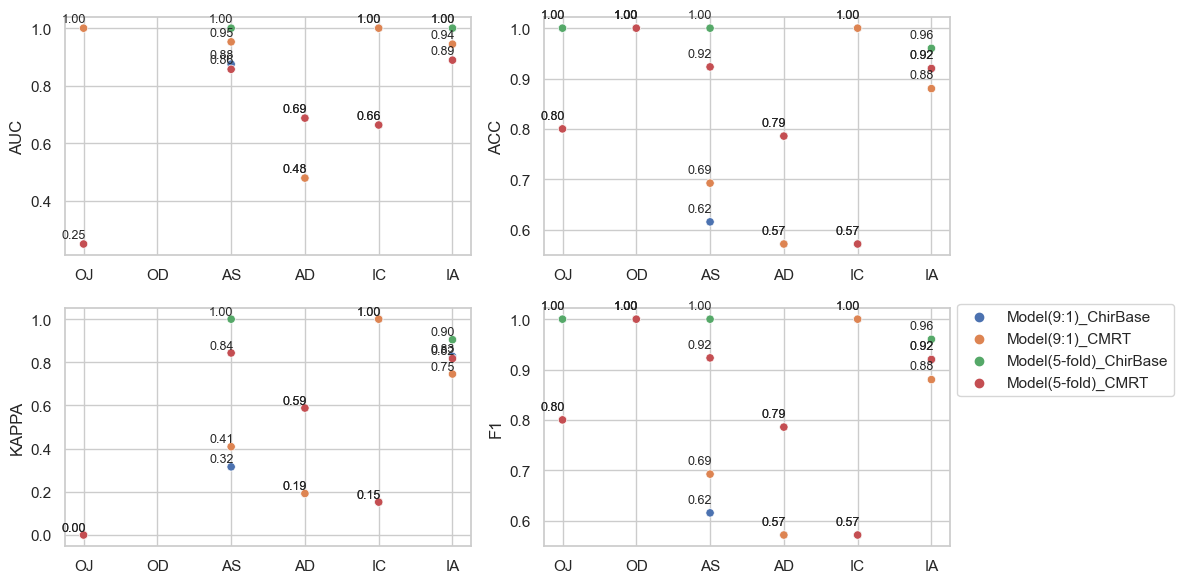

In [53]:
sns.set_theme()
sns.set_style("whitegrid")

CSP_dict = {'OJ': 0, 'OD': 1, 'AS': 2, 'AD': 3, 'IC': 4, 'IA': 5}

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.scatterplot(data=df_res_overlap_all, x="Short_Name", y="AUC", hue='Label', ax=axs[0, 0], legend=False)
axs[0, 0].set(xlabel=None)

sns.scatterplot(data=df_res_overlap_all, x="Short_Name", y="ACC", hue='Label', ax=axs[0, 1], legend=False)
axs[0, 1].set(xlabel=None)

sns.scatterplot(data=df_res_overlap_all, x="Short_Name", y="KAPPA", hue='Label', ax=axs[1, 0], legend=False)
axs[1, 0].set(xlabel=None)

sns.scatterplot(data=df_res_overlap_all, x="Short_Name", y="F1", hue='Label', ax=axs[1, 1])
axs[1, 1].set(xlabel=None)
axs[1, 1].legend(bbox_to_anchor=(1, 1.05))

for i, point in df_res_overlap_all.iterrows(): 
    axs[0, 0].text(CSP_dict[point['Short_Name']]-0.3, point['AUC']+0.02, '{:.2f}'.format(point['AUC']), fontsize=9)
    axs[0, 1].text(CSP_dict[point['Short_Name']]-0.3, point['ACC']+0.02, '{:.2f}'.format(point['ACC']), fontsize=9)
    axs[1, 0].text(CSP_dict[point['Short_Name']]-0.3, point['KAPPA']+0.02, '{:.2f}'.format(point['KAPPA']), fontsize=9)
    axs[1, 1].text(CSP_dict[point['Short_Name']]-0.3, point['F1']+0.02, '{:.2f}'.format(point['F1']), fontsize=9)
    
fig.tight_layout()
# plt.savefig('./test_cmrt_overlap.eps', dpi=600, bbox_inches='tight', format='eps')
# plt.savefig('./test_cmrt_overlap.png', dpi=600, bbox_inches='tight')
plt.show()

## 5. Compare with qGeoGNN

In [54]:
dfs = []
qgeognn_res_path = '/data/yuhhong/qGeoGNN_rt/results/'
files_list = [f for f in os.listdir(qgeognn_res_path) if not f.endswith('_post.csv')]

for f in files_list:
    df_tmp = pd.read_csv(os.path.join(qgeognn_res_path, f), sep='\t', index_col=0)
    df_tmp['Column'] = f.replace('.csv', '')
    dfs.append(df_tmp)

df_qgeognn = pd.concat(dfs)

df_qgeognn = df_qgeognn[['SMILES', 'Column', 'Y_Pred']]

FileNotFoundError: [Errno 2] No such file or directory: '/data/yuhhong/qGeoGNN_rt/results/'

In [ ]:
data_dfs = []
for csp in ['ADH', 'ODH', 'OJ', 'OD', 'AS', 'AD', 'IA', 'IC']:
    df_tmp = pd.read_csv('/data/yuhhong/qGeoGNN_rt/dataset/{}_charity_0823.csv'.format(csp), index_col=0)
    data_dfs.append(df_tmp)
    
df_qgeognn_data = pd.concat(data_dfs)

df_qgeognn_data = df_qgeognn_data.drop(['Unnamed: 0'], axis=1)

df_qgeognn_data = df_qgeognn_data[['index', 'SMILES', 'RT', 'Speed', 'Column']]

In [ ]:
df_qgeognn = df_qgeognn.merge(df_qgeognn_data, on=['SMILES', 'Column'], how='left')

In [ ]:
grouped = df_qgeognn.groupby(by=['index', 'Column'])
df1 = grouped.filter(lambda x: len(x) == 1)
df2 = grouped.filter(lambda x: len(x) > 1)

Half predicted & half labeled 

In [ ]:
df1 = df_qgeognn_data[df_qgeognn_data['index'].isin(df1['index'])].merge(df1, on=['index', 'Column'], how='right')

df1 = df1[df1['SMILES_x'] != df1['SMILES_y']]

df1['RT_Pred'] = df1.apply(lambda x: x['Y_Pred']/x['Speed_y'], axis=1)

df1 = df1[(df1['RT_x'] != 0) & (df1['RT_y'] != 0) & (df1['RT_Pred'] != 0)]

df1['K2/K1'] = df1.apply(lambda x: (max(x['RT_x'], x['RT_y']) - 2.9) / (min(x['RT_x'], x['RT_y']) - 2.9), axis=1)
df1['K2/K1_Pred'] = df1.apply(lambda x: (max(x['RT_x'], x['RT_Pred']) - 2.9) / (min(x['RT_x'], x['RT_Pred']) - 2.9), axis=1)

In [ ]:
df1 = df1.merge(df_csp, left_on='Column', right_on='Short_Name', how='left').dropna()
df1['Pred_qgeognn'] = df1.apply(lambda x: convert2cls(x['K2/K1_Pred'], x['CSP_Category']), axis=1)
df1['Pred_qgeognn_b'] = df1['Pred_qgeognn'].apply(binary_cls)

df1.reset_index(drop=True, inplace=True)

In [ ]:
df1['SMILES'] = df1['SMILES_x'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [ ]:
df1 = df1.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [ ]:
f1 = metrics.f1_score(df1['Class_b'], df1['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df1['Class_b'], df1['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df1['Class_b'], df1['Pred_qgeognn_b'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df1['Class_b'], df1['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Class_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Class_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Class_b'], df1['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
pred = np.array(df1.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)
    
f1 = metrics.f1_score(pred, df1['Class_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df1['Class_b'])
acc = metrics.accuracy_score(pred, df1['Class_b'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df1['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Class_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Class_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Class_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
pred = np.array(df1.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.9, 1, 0)

f1 = metrics.f1_score(pred, df1['Class_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df1['Class_b'])
acc = metrics.accuracy_score(pred, df1['Class_b'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df1['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Class_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Class_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Class_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Totally predicted

In [ ]:
df2['RT_Pred'] = df2.apply(lambda x: x['Y_Pred'] / x['Speed'], axis=1)

df_alpha = df2.groupby('index').apply(lambda x: (x['RT'].max() - 2.9) / (x['RT'].min() -2.9)).to_frame(name='K2/K1')
df_alpha_pred = df2.groupby('index').apply(lambda x: (x['RT_Pred'].max() - 2.9) / (x['RT_Pred'].min() -2.9)).to_frame(name='K2/K1_Pred')

df2 = df_alpha.merge(df2, on='index', how='left')
df2 = df2.merge(df_alpha_pred, on='index', how='left')

In [ ]:
df2 = df2.merge(df_csp, left_on='Column', right_on='Short_Name', how='left').dropna()
df2['Pred_qgeognn'] = df2.apply(lambda x: convert2cls(x['K2/K1_Pred'], x['CSP_Category']), axis=1)
df2['Pred_qgeognn_b'] = df2['Pred_qgeognn'].apply(binary_cls)

df2.reset_index(drop=True, inplace=True)

In [ ]:
df2['SMILES'] = df2['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [ ]:
df2 = df2.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [ ]:
f1 = metrics.f1_score(df2['Class_b'], df2['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df2['Class_b'], df2['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df2['Class_b'], df2['Pred_qgeognn_b'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df2['Class_b'], df2['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Class_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Class_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Class_b'], df2['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
pred = np.array(df2.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)
    
f1 = metrics.f1_score(pred, df2['Class_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df2['Class_b'])
acc = metrics.accuracy_score(pred, df2['Class_b'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df2['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Class_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Class_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Class_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
df2['Class_b'].tolist()

In [ ]:
pred

In [ ]:
plot_roc_curve_b(pred, df2['Class_b'].tolist())

All 

In [ ]:
df_all = pd.concat([df1[['Class_b', 'Pred_qgeognn_b', 'Pred_b']],
                  df2[['Class_b', 'Pred_qgeognn_b', 'Pred_b']]])

In [ ]:
f1 = metrics.f1_score(df_all['Class_b'], df_all['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df_all['Class_b'], df_all['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df_all['Class_b'], df_all['Pred_qgeognn_b'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], df_all['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Class_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Class_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Class_b'], df_all['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
pred = np.array(df_all.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)

f1 = metrics.f1_score(pred, df_all['Class_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df_all['Class_b'])
acc = metrics.accuracy_score(pred, df_all['Class_b'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Class_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Class_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Class_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
pred = np.array(df_all.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.9, 1, 0)

f1 = metrics.f1_score(pred, df_all['Class_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df_all['Class_b'])
acc = metrics.accuracy_score(pred, df_all['Class_b'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Class_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Class_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Class_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
plot_roc_curve_b(pred, df_all['Class_b'].tolist())